In [0]:
#Importing packages

import numpy as np
import matplotlib.pyplot as plt

# **Python Simulation Code **


In [0]:
class TrafficSimulation:
    '''
        Simulates the traffic flow and creates a new traffic simulation object. 
        
        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            traffic_density (float) The fraction of cells that have a car in them.
              Default: 0.2.

            p_slowing (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_velocity (int) The maximum speed in car cells per update step.
              Default: 5.
              
            num_lanes (int) The number of lanes in on road. Default: 1.
            
            p_of_swapping (float) The probability that a car would switch to 
            another lane if other conditions are met. Default: 0.5.
              
            good_behaviour (boolean) Deciding what strategy of swapping lanes to
            use, to represent good or bad driver behaviour for stretch goal.
            Default: True.         
              
    '''
    
    def __init__(self, road_length=100, traffic_density=0.2, p_slowing=0.5, 
        max_velocity=5, num_lanes = 1, p_of_swapping= 0.5,good_behaviour = True):
      
        
        self.road_length = road_length
        self.traffic_density = traffic_density
        self.p_slowing = p_slowing
        self.max_velocity = max_velocity
        
        self.num_lanes = num_lanes
        self.p_of_swapping = p_of_swapping
        self.good_behaviour = good_behaviour
        
        
        # Track the time steps and total number of cars that passed the simulation
        # periodic boundary to estimate average traffic flow.
        
        self.flow_counter = 0 
        self.time_step = 0
        
        #Initialising the cars
        self.initialize_cars()
        
        
    def initialize_cars(self):
        '''
        Creating the cars with random starting velocities,
        that are distributed randomly along the road, with the same density 
        of cars for each lane. -1 represents empty cells.
        '''
    
        self.current_state = -np.ones((self.num_lanes, self.road_length), dtype=int)  
        for lane in range(self.num_lanes):
    
            cars = np.random.choice(range(self.road_length), 
                                    size=int(round(self.road_length * self.traffic_density)), 
                                    replace=False)

            self.current_state[lane][cars] = np.random.randint(0, self.max_velocity + 1, size=len(cars))
            
            
    
    def swap_lanes_good_behaviour(self):
        
        '''
        Using the original lane changing rules from Ricket M et.al (1996)
        for a multi-lane traffic simulation, to determine whether cars switch lanes or not.
        The different checks/ rules before switching is approved are listed in order 
        and a lane switch happens if all conditions are met.
        
        '''
       
        change_of_lanes_state = -np.ones((self.num_lanes, self.road_length), dtype=int)
        
        #Storing the possible lane combinations for switching
        
        lane_switch_combinations = [[lane, 1+lane] for lane in range(self.num_lanes - 1)]
        
        for combo in lane_switch_combinations: #For each lane combination
            change_of_lanes_state[min(combo)] = -np.ones(self.road_length, dtype=int) #Serves as a check
            
            for lane in combo: #For each lane in combination
                for car in range(self.road_length): #For each cell in lane
                    if self.current_state[lane][car] > -1: #If cell is a car 

                        #Rule 1: To switch, there should not be enough space for car to move forward in its current lane at its current speed.
                        
                        gap_in_lane = 0
                        while self.current_state[lane][(car+gap_in_lane+1) % self.road_length] == -1: 
                                gap_in_lane +=1

                        condition_one =  gap_in_lane < self.current_state[lane][car] +1

                        
                        #Rule 2: To switch, there should be enough space for car to move forward in the other lane at its current speed.
                        #Checks first if there is a car beside it, at the same position in other lane.
                        
                        gap_in_other_lane = -1 
                        while self.current_state[(max(combo)-lane)+ min(combo)][(car+gap_in_other_lane+1) % self.road_length] == -1:
                            gap_in_other_lane +=1

                        condition_two = gap_in_other_lane > self.current_state[lane][car] +1
                           
                            
                        #Rule 3: To switch, it should not be possible for a car in the other lane to drive into car.
                        #This is checked by ensuring the gap behind is greater than any car's max_velocity.
                        #Checks first if there is a car beside it, at the same position in other lane.
                           
                        gap_behind_in_other_lane = 1 #so that the first cell checked is the one beside it
                        while self.current_state[(max(combo)-lane)+ min(combo)][(car+gap_behind_in_other_lane-1) % self.road_length] == -1: 
                                gap_behind_in_other_lane -=1

                        condition_three = abs(gap_behind_in_other_lane) > self.max_velocity    
                           
                            
                        #Rule 4: Randomisation (a number randomly generated must be less than the probability of switching)
                        condition_four = np.random.uniform() < self.p_of_swapping
                            
                        
                        #If all conditions/ rules are met, car moves to other lane, else, stays in its own lane.   
                        if condition_one and condition_two and condition_three and condition_four:
                            change_of_lanes_state[(max(combo)-lane)+ min(combo)][car] = self.current_state[lane][car]
                        else:
                            change_of_lanes_state[lane][car] = self.current_state[lane][car]
                            
            
            #Updates current state after switching cars(or not) for all lanes.            
            for lane in combo:
                self.current_state[lane] = change_of_lanes_state[lane]
                
            
    
    def swap_lanes_bad_behaviour(self):
        
        '''
        For stretch goal. Models a bad driver behaviour for a multi-lane model, 
        where the driver switches definitely if there is more space in the other
        lane ahead, compared to driver's current lane. Driver doesn't do a look 
        back.
        
        '''
        change_of_lanes_state = -np.ones((self.num_lanes, self.road_length), dtype=int)
        
        #Storing the possible lane combinations for switching
        
        lane_switch_combinations = [[lane, 1+lane] for lane in range(self.num_lanes - 1)]
            
        for combo in lane_switch_combinations: #For each lane combination
            change_of_lanes_state[min(combo)] = -np.ones(self.road_length, dtype=int) #Serves as a check
            
            for lane in combo: #For each lane in combination
                for car in range(self.road_length): #For each cell in lane
                    if self.current_state[lane][car] > -1: #If cell is a car 

                        #Get forward-looking gap in current lane.
                        
                        gap_in_lane = 0
                        while self.current_state[lane][(car+gap_in_lane+1) % self.road_length] == -1: 
                                gap_in_lane +=1

                        #Get forward-looking gap in other lane.          
               
                        gap_in_other_lane = -1 
                        while self.current_state[(max(combo)-lane)+ min(combo)][(car+gap_in_other_lane+1) % self.road_length] == -1: 
                                gap_in_other_lane +=1

                        #Switches definitely if the forward-looking gap in the other lane 
                        #is greater than the forward- looking gap in the current lane
                        #Else,car stays in its own lane.
                        
                        if gap_in_other_lane > gap_in_lane:
                            change_of_lanes_state[(max(combo)-lane)+ min(combo)][car] = self.current_state[lane][car]
                        else:
                            change_of_lanes_state[lane][car] = self.current_state[lane][car]
                            
                            
        #Updates current state after switching cars(or not) for all lanes.                    
        for lane in combo:
                self.current_state[lane] = change_of_lanes_state[lane]
                
               
               
    def update(self):
        '''
        Updates the simulation by one time step in one lane, using rules in 
        Nagel & Schreckenberg and Ricket M et.al (1996)
        '''
        
        for lane in range(self.num_lanes): #For each lane
                for car in range(self.road_length): #For each cell
                    if self.current_state[lane][car] > -1: #If cell is a car

                        # Step 1: Acceleration: by default increasing it 1
                        if self.current_state[lane][car]< self.max_velocity:
                            self.current_state[lane][car] += 1

                        # Step 2: Slowing Down car based on neighbors

                        distance = 1
                        while self.current_state[lane][(car+distance) % self.road_length] == -1: 
                                distance +=1

                        if self.current_state[lane][car] >= distance:
                             self.current_state[lane][car] = distance - 1

                        # Step 3: Slowing down the car based on random probability if the car's velocity is greater than 0
                        
                        if (np.random.uniform() < self.p_slowing) and (self.current_state[lane][car] > 0):                        
                            self.current_state[lane][car] -= 1
                

        #Move cars using their updated velocities
        
        next_state = -np.ones((self.num_lanes, self.road_length), dtype=int) 

        for lane in range(self.num_lanes):
            for car in range(self.road_length):
                if self.current_state[lane][car] > -1:
                    next_state[lane][(car + self.current_state[lane][car]) % self.road_length] =  self.current_state[lane][car]
        
        self.current_state = next_state         
              


    def flow_updater(self, display= True):
        
        '''
        Combines all the other functions and runs the simulation, 
        to update time and traffic flow.
        '''
        
        if self.num_lanes >1: #Calls swap lanes function only for multi-lane models
            if self.good_behaviour: #Choosing the strategy for swapping lanes to show good or bad driver behaviour(stretch goal)
                self.swap_lanes_good_behaviour()
            else:
                self.swap_lanes_bad_behaviour()
        self.update() 
        if display:
            self.display()

        #Updating time and traffic flow
        
        self.time_step += 1       
    
        for lane in range(self.num_lanes):
            for car in range(self.road_length):
                if (car+ self.current_state[lane][car]) >= self.road_length:
                    self.flow_counter += 1
                
    def display(self):
        '''
            Displays the current state of simulation, the cars are represented by
            a number greater than or equals to 0. The number represents the velocity
            of car. The empty spaces is shown as dots.
        '''
        for lane in self.current_state:
            print(''.join(['.' if x == -1 else str(x) for x in lane]))
        if self.num_lanes >1: print ('\n') #Printing new line to show difference in lane updates for multi-lane models.

## **Plotting and Running Experiment Code **

In [0]:
#Plotting the mean and confidence interval for each average flow, and for each density.

def plotting_means_and_CI(density_list, mean_average_flow, mean_average_flow_lower_bound, mean_average_flow_upper_bound, label_name):
    
    plt.fill_between(density_list, mean_average_flow_upper_bound, mean_average_flow_lower_bound, alpha=.2)
    plt.plot(density_list, mean_average_flow, label = label_name)
    plt.xlabel('Densities')
    plt.ylabel('Flow')

    

def run_experiment(num_simulations, num_steps, simulation, densities, num_lanes, good_behaviour):
    '''
        Running the simulation *num_simulations* times to find the average flow of the simulation
        for different *densities* (list) after *num_steps* time steps.
    '''
    
    density_list = [] #list containing densities
    mean_average_flow = [] 
    mean_average_flow_upper_bound = []
    mean_average_flow_lower_bound = []

    
    for density in densities:
        avg_flow = []
        for i in range(num_simulations):
            sim = TrafficSimulation(traffic_density=density,num_lanes = num_lanes, good_behaviour = good_behaviour)
            for _ in range(num_steps):
                sim.flow_updater(display= False)
            avg_flow.append(sim.flow_counter / float((sim.num_lanes*sim.time_step)))
        
        # Finding mean and confidence interval for average flows
        confidence_interval = np.percentile(avg_flow, [2.5, 97.5])
        mean_average_flow.append(np.mean(avg_flow))
        mean_average_flow_lower_bound.append(confidence_interval[0])
        mean_average_flow_upper_bound.append(confidence_interval[1])
        density_list.append(density)

    return (density_list, mean_average_flow, mean_average_flow_lower_bound, mean_average_flow_upper_bound)


#Part 1: Traffic jams on a circular road

### Visualizing the state of this model over time, to show how traffic jams can appear when traffic density is high enough.

In [116]:
def traffic_jam_display(sim):
    print('Initial State')
    sim.display()

    print('-'*20)
    print('Simulation Starts')
    print('-'*20)
    for i in range(10):
        sim.flow_updater()
        
        
for i in [0.2, 0.5, 0.8]:
    sim = TrafficSimulation(traffic_density = i,num_lanes = 1)
    print('When density is {0}'.format(i))
    print ('\n')
    traffic_jam_display(sim)
    print ('\n')

When density is 0.2


Initial State
............2......0..3............30....4...2.............5.4....05..0..4........2.3..4.5...55....3
--------------------
Simulation Starts
--------------------
..3............3....1.....4........0.1.....2...2...........0....3.0..20.......5...0...20....30...3..
.4...3.............4.1........4....0..1.......3..2.........0.....10..0.1.........30...00....00......
...2....3..........0..1..........3..1..1........2..2........1....0.1.0..1........00...00....00......
......3.....4.......1...2.........1..1..1........1....3......1...0..10...1.......00...0.1...0.1.....
.........3.......5....2....3.......1...2.1........1.......4....2..1.00.....2.....00...0..1...1.1....
.............4.......4...3.....4....1..0..1........1..........4.1..10.1.......3..0.1...1...2..1.1...
.................4.....2.....4....3..1.0....2........2........0...20.1..2.......20..1...1...1..1.1..
......................5...3......4..20.0.......3........3.....0...00..1...2.....0.1...2...2..1.0

### Analyzing how the overall average traffic flow rate varies with traffic density

[0.0, 0.3834, 0.2975, 0.26695, 0.23660000000000003, 0.2022, 0.16475, 0.13055000000000003]


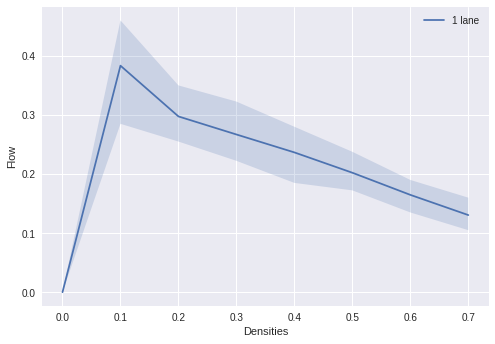

In [117]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = 1
good_behaviour = True

results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, num_lanes, good_behaviour)

plotting_means_and_CI(*results, '1 lane')
plt.legend()

print(results[1])

#Part 2: Multi-lane highways

### Visualizing the state of this model over time, to show how traffic jams can appear when traffic density is high enough.

In [118]:
for i in [0.2, 0.5, 0.8]:
    sim = TrafficSimulation(traffic_density = i,num_lanes = 2)
    print('When density is {0}'.format(i))
    print ('\n')
    traffic_jam_display(sim)
    print ('\n')

When density is 0.2


Initial State
....4.3....3..45....2...4.......................0.4...5...4...........3..412.........021..4......3..
...........0.5.2..5.5...0.............4....14.....5...5.2..3...1.....2.....3....5...1...2.......1...


--------------------
Simulation Starts
--------------------
3....1....4.1.0...3....3....4.............4......1..2....3.....5........200...3......00..2.....5....
............1.1.1..1...30..................0....4...2..1.1....3.1.......3.....3...2...2...2......1..


...3..1...0..10......3....3......5.............5..1...2......4.....4....000......3...00....2.......4
............0..1..2..2.0.1..................1.....2...20..1...0...2.........4....3..2...2...2.....1.


.2...2.1...1.0.1........3....3........5.........1..1....2.........5....400.1........30.1......3.....
2............1...2..2.10...2..................2......30.1...2.0......3..........4..2..2....3...3....


....30...2.0.0..1..........3....3..........5.....1..1.....2...........4000..1.......00..

### Analyzing how much more traffic can flow through a 2-lane road, compared to a single lane road, at the same traffic density

[0.0, 0.3718000000000001, 0.29795, 0.2707, 0.23959999999999998, 0.20250000000000004, 0.16670000000000001, 0.1297]
[0.0, 0.38055000000000005, 0.3098, 0.2779, 0.24097499999999997, 0.202025, 0.1666, 0.129875]


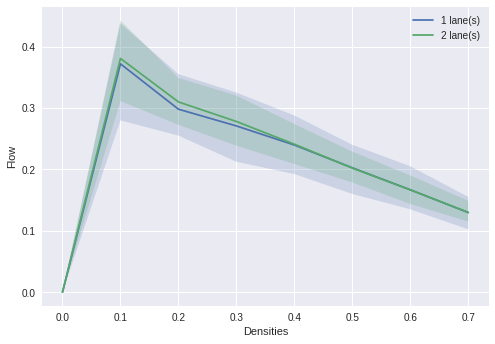

In [119]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = [1,2]
good_behaviour = True

for i in num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, i, good_behaviour)
    plotting_means_and_CI(*results,'{0} lane(s)'.format(i))
    print(results[1])
   

plt.legend()

### Analyzing how much more traffic can flow through a 3-lane road, compared to a single lane road, at the same traffic density

[0.0, 0.3767000000000001, 0.2981, 0.2698, 0.23935000000000003, 0.20159999999999997, 0.16580000000000006, 0.12735]
[0.0, 0.38886666666666664, 0.31805000000000005, 0.28008333333333346, 0.24009999999999998, 0.20295000000000002, 0.16738333333333333, 0.12860000000000002]


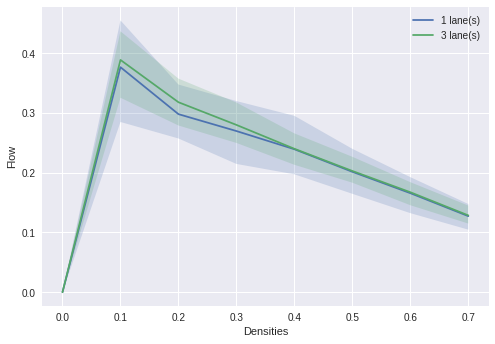

In [120]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = [1,3]
good_behaviour = True

for i in num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, i, good_behaviour)
    plotting_means_and_CI(*results,'{0} lane(s)'.format(i))
    print(results[1])
   
plt.legend()

### Analyzing how much more traffic can flow through a 4-lane road, compared to a single lane road, at the same traffic density

[0.0, 0.376, 0.29685, 0.27099999999999996, 0.2342, 0.20489999999999997, 0.16670000000000001, 0.12885]
[0.0, 0.388425, 0.3172375, 0.2804999999999999, 0.24226249999999996, 0.20403749999999998, 0.1682625, 0.12988750000000002]


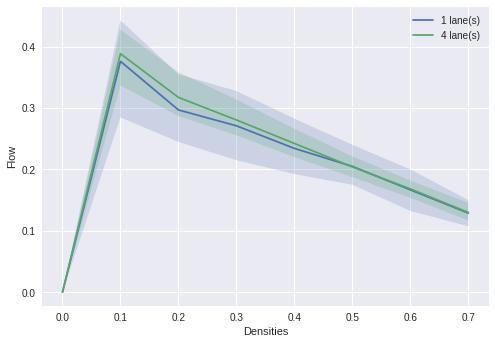

In [121]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = [1,4]
good_behaviour = True

for i in num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, i, good_behaviour)
    plotting_means_and_CI(*results,'{0} lane(s)'.format(i))
    print(results[1])
   
plt.legend()

### Analyzing how much more traffic can flow through a 3-lane road, compared to a single lane and a 2-lane road, at the same traffic density

[0.0, 0.36920000000000003, 0.30005000000000004, 0.27265, 0.2385, 0.20130000000000003, 0.16905, 0.1298]
[0.0, 0.38275000000000015, 0.312225, 0.27275000000000005, 0.2405749999999999, 0.20650000000000002, 0.16605, 0.1285]
[0.0, 0.3904166666666667, 0.31245, 0.2784333333333333, 0.24020000000000002, 0.20331666666666667, 0.16811666666666666, 0.12906666666666664]


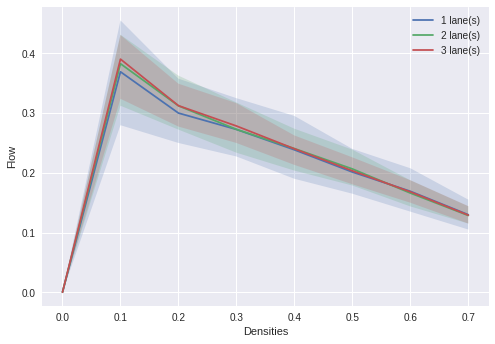

In [122]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = [1,2,3]
good_behaviour = True

for i in num_lanes:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, i, good_behaviour)
    plotting_means_and_CI(*results,'{0} lane(s)'.format(i))
    print(results[1])
   
plt.legend()

# Stretch Goal 1: Good and Bad Driver Behaviour

For this stretch goal, I focused on changing the original switching lanes function, to reflect good and bad driver behaviour. 
The original switching lanes function serves as good driver behaviour, because the driver looks back to see if there is enough space behind him/her so as to not cause traffic if he/ she switches lanes. 
In the bad driver behaviour, the driver does not look back at all, and switches definitely if the space in front in the other lane is more than the space in his current lane.

For this analysis, I would be using a 2-lane model.

## Traffic jams

### Good driver behaviour

In [0]:
for i in [0.2, 0.5, 0.8]:
    sim = TrafficSimulation(traffic_density = i,num_lanes = 2)
    print('When density is {0}'.format(i))
    print ('\n')
    traffic_jam_display(sim)
    print ('\n')

When density is 0.2


Initial State
..355........4..5...2...5.44......3.......3.2...4.3..........24.1....1....0.......5.................
..1..21.......3....3.0....4...3.......1...4.5.4.0....5.0.4..........................5....20......4..


--------------------
Simulation Starts
--------------------
..00....4.....1....3..2.0.0.....5....3....0...2.0....3.......00..1.....2..0...........4.....3.......
.4..20.1..........40..1.....2.....4....1..0.0..10.....1.1....4..........................4..1........


..0.1........5.1.....20.0..1........4....4.1...1.1.......4...0.1..1.....1.0................5...3....
..1.00...2........00...1......2......3...2.1.1.0.1.....1..2......4........................2.1.......


...1.1.......0..1....0.1.1...2..........40..1...1..2........3.1..2.1....0.0..................2....3.
...100.....2......0.1...1.......2.......30.0..1.1..2.....2...3.......4....................0...2.....


.3..1..2.....0...1...0..1.1.....3.......00....2..1...2......0..1.0...2..0..1............

### Bad driver behaviour

In [0]:
for i in [0.2, 0.5, 0.8]:
    sim = TrafficSimulation(traffic_density = i,num_lanes = 2, good_behaviour = False)
    print('When density is {0}'.format(i))
    print ('\n')
    traffic_jam_display(sim)
    print ('\n')

When density is 0.2


Initial State
3..............4..0.540....4..0.5.4..3..1.3...........1.....0..............4............5..00......5
...15..1.5...2..........2............4.3......4.5...035.5........0.....52...3..5...........3........


--------------------
Simulation Starts
--------------------
..20..2.1.....5........1............2...3....30...2..1..2....1....1.......30...3..........20........
...4.........0...20.0..2..2..2.1...3..10..2..........00......5.............3.......4.......0.1......


..0.1....1......200......2.1.0...2..0.0....3.......1...2..2....2..........00......3.......0.1.......
.....2...3....1......1....3..........2..1..1.0.1.....0.1.........4..2..........4.......4....1.1.....


.....1.....2......0.........3.......0.0.....1.1.....1.....3.....1.....5.....1........3.....1.1......
..0....2.....40.00....1...0.10......3..2..2.1....2...0...2...3........2...0.........5......40..1....


.......2...0.0.1.1.1....2.......4...0.0..2..0...2...00.......3...1.........5..2.........

## Traffic flow

[0.0, 0.38595, 0.312525, 0.27615, 0.240625, 0.20382499999999998, 0.16662500000000002, 0.128575]
[0.0, 0.230625, 0.25785, 0.257075, 0.23904999999999998, 0.20764999999999997, 0.173275, 0.135225]


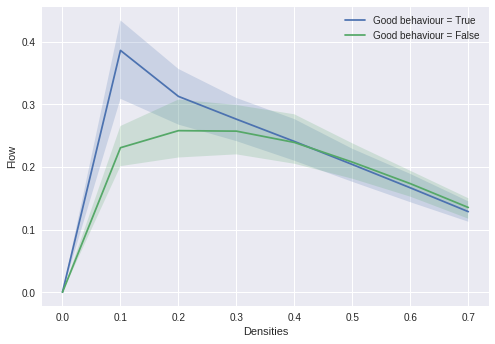

In [0]:
densities = np.arange(0,0.8,0.1)
num_simulations = 100
num_steps = 200
num_lanes = 2
good_behaviour = [True, False]

for i in good_behaviour:
    results = run_experiment(num_simulations, num_steps, TrafficSimulation, densities, num_lanes, i)
    plotting_means_and_CI(*results,'Good behaviour = {0}'.format(i))
    print(results[1])
   
plt.legend()

From the graph above, we can see that with bad driver behaviour, traffic flow is greatly reduced in comparison to good driver behaviour. The implications of this result in relation to self-driving cars would be discussed in the report.

